<a href="https://colab.research.google.com/github/aniket-alt/CMPE-258-Deep-Learning/blob/main/Assignment%20-%203/colab_c_pytorch_classes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Colab c) 3-Layer Deep Neural Network using PyTorch nn.Module

**CMPE 258 - Deep Learning Assignment**

## Objective
Implement a 3-layer deep neural network for non-linear regression using **PyTorch's built-in modules**: `nn.Module`, `nn.Linear`, `nn.Sequential`, and standard optimizers.

### Key Components Used:
- `nn.Module` for model definition
- `nn.Linear` for fully connected layers
- `nn.Tanh` for activation functions
- `nn.MSELoss` for loss computation
- `torch.optim.Adam` for optimization

## Target Function
$$y = \sin(x_1) \cdot \cos(x_2) + x_3^2 + 0.5 \cdot x_1 \cdot x_2$$

## Network Architecture
```
Input (3) → Hidden1 (64, Tanh) → Hidden2 (32, Tanh) → Output (1)
```

## 1. Import Libraries and Setup

We import PyTorch with its neural network module (`torch.nn`) which provides high-level building blocks for neural networks.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"PyTorch version: {torch.__version__}")
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.10.0+cu128
Using device: cuda
GPU: Tesla T4


## 2. Define the Target Non-Linear Function

This is the ground truth function our neural network will learn to approximate.

In [2]:
def target_function(x1, x2, x3):
    """
    Non-linear target function with 3 variables:
    y = sin(x1) * cos(x2) + x3^2 + 0.5 * x1 * x2
    """
    return np.sin(x1) * np.cos(x2) + x3**2 + 0.5 * x1 * x2

print("Function test: f(1, 1, 1) =", target_function(1, 1, 1))

Function test: f(1, 1, 1) = 1.954648713412841


## 3. Generate and Prepare Data

We create synthetic data and use `DataLoader` for efficient batch processing during training. This is a standard PyTorch pattern for handling datasets.

In [3]:
def generate_data(n_samples=2000, noise_std=0.05):
    """
    Generate synthetic data for training and testing.
    """
    x1 = np.random.uniform(-2, 2, n_samples)
    x2 = np.random.uniform(-2, 2, n_samples)
    x3 = np.random.uniform(-2, 2, n_samples)

    X = np.column_stack([x1, x2, x3]).astype(np.float32)
    y = target_function(x1, x2, x3) + np.random.normal(0, noise_std, n_samples)
    y = y.reshape(-1, 1).astype(np.float32)

    return torch.tensor(X), torch.tensor(y)

# Generate data
X_train, y_train = generate_data(n_samples=2000)
X_test, y_test = generate_data(n_samples=500)

# Create DataLoader for batch processing
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")
print(f"Batch size: {batch_size}")
print(f"Training batches per epoch: {len(train_loader)}")

Training samples: 2000
Test samples: 500
Batch size: 64
Training batches per epoch: 32


## 4. Define Neural Network Model using nn.Module

This is the core of PyTorch's object-oriented approach. We define a class that inherits from `nn.Module` and implement:
- `__init__`: Define layers
- `forward`: Define computation flow

We show two equivalent approaches:
1. **Sequential approach**: Using `nn.Sequential` to chain layers
2. **Custom forward approach**: Defining layers separately and implementing forward manually

In [4]:
class NeuralNetworkSequential(nn.Module):
    """
    3-Layer Neural Network using nn.Sequential.

    This approach chains all layers together in a single sequential block.
    Clean and concise for simple feed-forward networks.
    """

    def __init__(self, input_size=3, hidden1_size=64, hidden2_size=32, output_size=1):
        super(NeuralNetworkSequential, self).__init__()

        self.network = nn.Sequential(
            # Layer 1: Input -> Hidden1
            nn.Linear(input_size, hidden1_size),
            nn.Tanh(),

            # Layer 2: Hidden1 -> Hidden2
            nn.Linear(hidden1_size, hidden2_size),
            nn.Tanh(),

            # Layer 3: Hidden2 -> Output
            nn.Linear(hidden2_size, output_size)
            # No activation for regression output
        )

    def forward(self, x):
        return self.network(x)


class NeuralNetworkCustom(nn.Module):
    """
    3-Layer Neural Network with custom forward method.

    This approach defines layers separately and implements forward manually.
    More flexible for complex architectures with skip connections, etc.
    """

    def __init__(self, input_size=3, hidden1_size=64, hidden2_size=32, output_size=1):
        super(NeuralNetworkCustom, self).__init__()

        # Define layers separately
        self.fc1 = nn.Linear(input_size, hidden1_size)
        self.fc2 = nn.Linear(hidden1_size, hidden2_size)
        self.fc3 = nn.Linear(hidden2_size, output_size)

        # Define activation function
        self.activation = nn.Tanh()

    def forward(self, x):
        # Layer 1
        x = self.fc1(x)
        x = self.activation(x)

        # Layer 2
        x = self.fc2(x)
        x = self.activation(x)

        # Layer 3 (output)
        x = self.fc3(x)

        return x


# Create model instances (we'll use the Sequential version)
model = NeuralNetworkSequential().to(device)

# Print model architecture
print("Model Architecture:")
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters())}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

Model Architecture:
NeuralNetworkSequential(
  (network): Sequential(
    (0): Linear(in_features=3, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): Tanh()
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
)

Total parameters: 2369
Trainable parameters: 2369


## 5. Define Loss Function and Optimizer

We use:
- **MSE Loss**: Standard loss for regression tasks
- **Adam Optimizer**: Adaptive learning rate optimizer that combines momentum and RMSprop

In [5]:
# Loss function
criterion = nn.MSELoss()

# Optimizer - Adam with learning rate 0.001
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

print(f"Loss function: {criterion}")
print(f"Optimizer: Adam")
print(f"Learning rate: {learning_rate}")

Loss function: MSELoss()
Optimizer: Adam
Learning rate: 0.001


## 6. Training Loop

The standard PyTorch training loop consists of:
1. Set model to training mode (`model.train()`)
2. Forward pass: Compute predictions
3. Compute loss
4. Zero gradients (`optimizer.zero_grad()`)
5. Backward pass (`loss.backward()`)
6. Update parameters (`optimizer.step()`)

We also evaluate on the test set periodically using `model.eval()` mode.

In [6]:
def train_model(model, train_loader, test_loader, criterion, optimizer,
                epochs=200, device='cpu', print_every=20):
    """
    Train the neural network model.

    Args:
        model: PyTorch model
        train_loader: DataLoader for training data
        test_loader: DataLoader for test data
        criterion: Loss function
        optimizer: Optimizer
        epochs: Number of training epochs
        device: 'cpu' or 'cuda'
        print_every: Print progress every N epochs

    Returns:
        train_losses: List of average training losses per epoch
        test_losses: List of test losses per epoch
    """
    train_losses = []
    test_losses = []

    print(f"Starting training for {epochs} epochs")
    print("=" * 60)

    for epoch in range(epochs):
        # ========== TRAINING PHASE ==========
        model.train()  # Set model to training mode
        epoch_loss = 0.0
        num_batches = 0

        for batch_X, batch_y in train_loader:
            # Move data to device
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)

            # Forward pass
            predictions = model(batch_X)

            # Compute loss
            loss = criterion(predictions, batch_y)

            # Backward pass
            optimizer.zero_grad()  # Clear previous gradients
            loss.backward()        # Compute gradients
            optimizer.step()       # Update parameters

            epoch_loss += loss.item()
            num_batches += 1

        avg_train_loss = epoch_loss / num_batches
        train_losses.append(avg_train_loss)

        # ========== EVALUATION PHASE ==========
        model.eval()  # Set model to evaluation mode
        test_loss = 0.0

        with torch.no_grad():  # Disable gradient computation
            for batch_X, batch_y in test_loader:
                batch_X = batch_X.to(device)
                batch_y = batch_y.to(device)

                predictions = model(batch_X)
                test_loss += criterion(predictions, batch_y).item()

        avg_test_loss = test_loss / len(test_loader)
        test_losses.append(avg_test_loss)

        # Print progress
        if (epoch + 1) % print_every == 0 or epoch == 0:
            print(f"Epoch {epoch+1:3d}/{epochs} | "
                  f"Train Loss: {avg_train_loss:.6f} | "
                  f"Test Loss: {avg_test_loss:.6f}")

    print("=" * 60)
    print(f"Training complete!")
    print(f"Final Train Loss: {train_losses[-1]:.6f}")
    print(f"Final Test Loss: {test_losses[-1]:.6f}")

    return train_losses, test_losses

# Train the model
train_losses, test_losses = train_model(
    model, train_loader, test_loader, criterion, optimizer,
    epochs=200, device=device, print_every=20
)

Starting training for 200 epochs
Epoch   1/200 | Train Loss: 2.931583 | Test Loss: 2.202020
Epoch  20/200 | Train Loss: 0.082171 | Test Loss: 0.082046
Epoch  40/200 | Train Loss: 0.023260 | Test Loss: 0.021649
Epoch  60/200 | Train Loss: 0.009154 | Test Loss: 0.008690
Epoch  80/200 | Train Loss: 0.006027 | Test Loss: 0.005694
Epoch 100/200 | Train Loss: 0.005146 | Test Loss: 0.005823
Epoch 120/200 | Train Loss: 0.004399 | Test Loss: 0.004953
Epoch 140/200 | Train Loss: 0.003994 | Test Loss: 0.004123
Epoch 160/200 | Train Loss: 0.004224 | Test Loss: 0.004064
Epoch 180/200 | Train Loss: 0.003741 | Test Loss: 0.004348
Epoch 200/200 | Train Loss: 0.003593 | Test Loss: 0.004028
Training complete!
Final Train Loss: 0.003593
Final Test Loss: 0.004028


## 7. Visualize Training Progress

Plotting the loss curves helps visualize the learning process and detect overfitting.

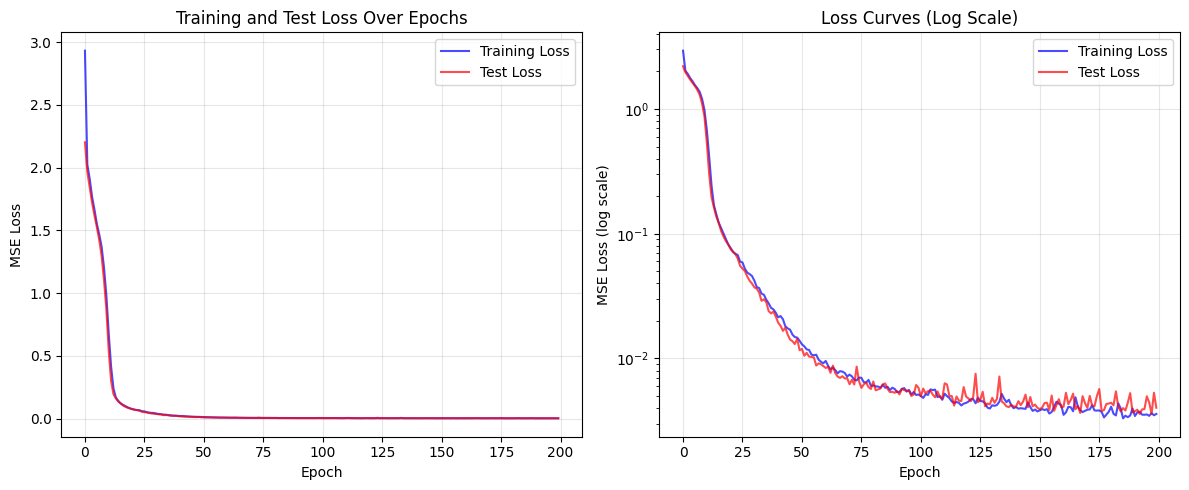

In [7]:
def plot_loss_curves(train_losses, test_losses):
    """
    Plot training and test loss curves.
    """
    plt.figure(figsize=(12, 5))

    # Plot 1: Full loss curve
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss', color='blue', alpha=0.7)
    plt.plot(test_losses, label='Test Loss', color='red', alpha=0.7)
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.title('Training and Test Loss Over Epochs')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot 2: Log scale
    plt.subplot(1, 2, 2)
    plt.plot(train_losses, label='Training Loss', color='blue', alpha=0.7)
    plt.plot(test_losses, label='Test Loss', color='red', alpha=0.7)
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss (log scale)')
    plt.title('Loss Curves (Log Scale)')
    plt.yscale('log')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

plot_loss_curves(train_losses, test_losses)

## 8. Evaluate Model Performance

We evaluate the trained model using various metrics and visualize predictions vs actual values.

Model Evaluation Metrics:
  MSE (Mean Squared Error):  0.004010
  RMSE (Root MSE):           0.063322
  MAE (Mean Absolute Error): 0.049806
  R² Score:                  0.998094


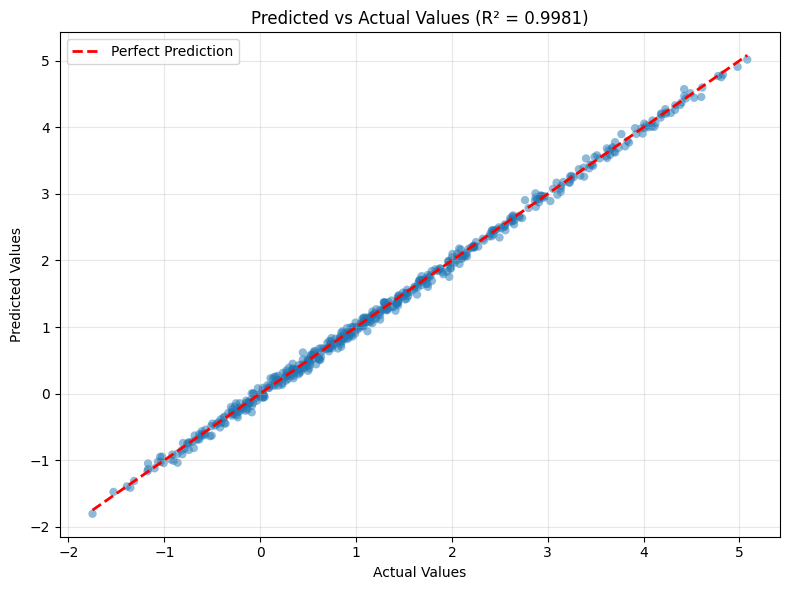

In [8]:
def evaluate_model(model, X_test, y_test, device):
    """
    Evaluate model performance with various metrics.
    """
    model.eval()

    with torch.no_grad():
        X_test_device = X_test.to(device)
        y_pred = model(X_test_device).cpu().numpy()

    y_test_np = y_test.numpy()

    # Calculate metrics
    mse = np.mean((y_pred - y_test_np)**2)
    mae = np.mean(np.abs(y_pred - y_test_np))
    rmse = np.sqrt(mse)

    # R-squared score
    ss_res = np.sum((y_test_np - y_pred)**2)
    ss_tot = np.sum((y_test_np - np.mean(y_test_np))**2)
    r2 = 1 - (ss_res / ss_tot)

    print("Model Evaluation Metrics:")
    print(f"  MSE (Mean Squared Error):  {mse:.6f}")
    print(f"  RMSE (Root MSE):           {rmse:.6f}")
    print(f"  MAE (Mean Absolute Error): {mae:.6f}")
    print(f"  R² Score:                  {r2:.6f}")

    # Scatter plot of predicted vs actual
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test_np, y_pred, alpha=0.5, edgecolors='none')
    plt.plot([y_test_np.min(), y_test_np.max()],
             [y_test_np.min(), y_test_np.max()], 'r--', lw=2, label='Perfect Prediction')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Predicted vs Actual Values (R² = {r2:.4f})')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    return y_pred, y_test_np

y_pred, y_test_np = evaluate_model(model, X_test, y_test, device)

## 9. 4D Visualization

We create visualizations to show the relationship between the 3 input variables and the predicted output.

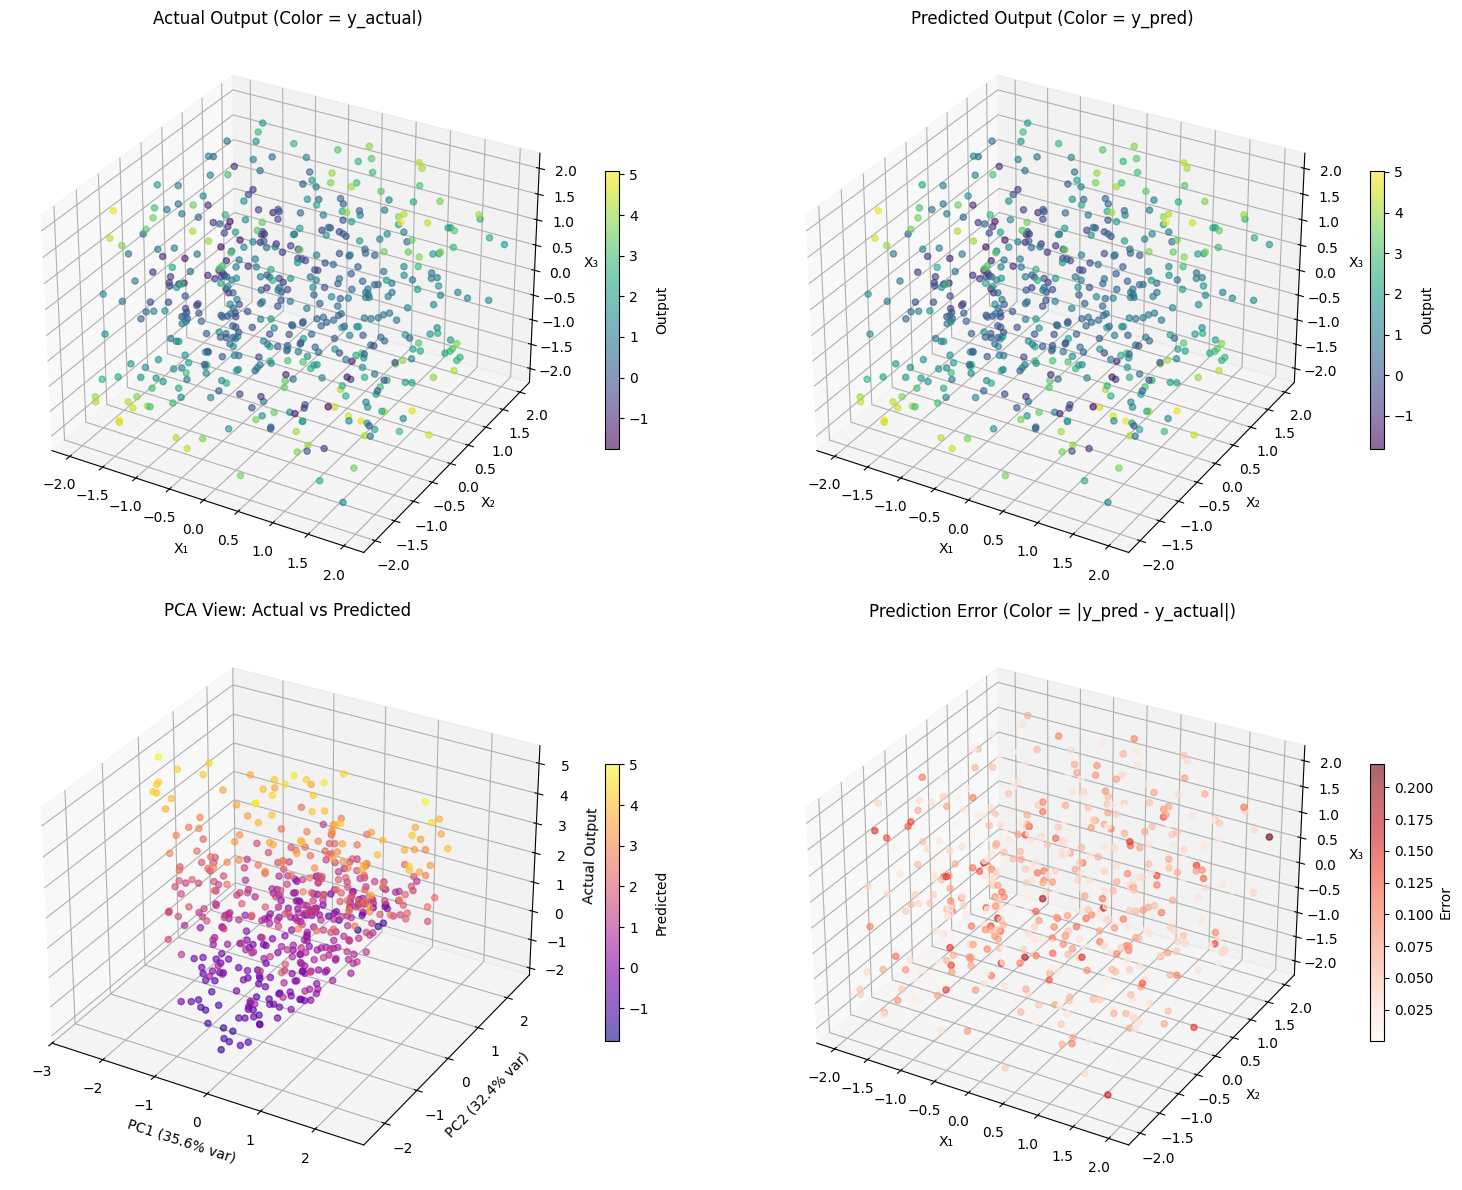


PCA Explained Variance Ratio: [0.35560745 0.32382295]


In [9]:
def plot_4d_visualization(model, X_test, y_test, device):
    """
    Create 4D visualizations of the neural network predictions.
    """
    model.eval()

    with torch.no_grad():
        X_test_device = X_test.to(device)
        y_pred = model(X_test_device).cpu().numpy().flatten()

    X_np = X_test.numpy()
    y_actual = y_test.numpy().flatten()

    fig = plt.figure(figsize=(16, 12))

    # ===== Plot 1: Direct 3D with color for actual output =====
    ax1 = fig.add_subplot(2, 2, 1, projection='3d')
    scatter1 = ax1.scatter(X_np[:, 0], X_np[:, 1], X_np[:, 2],
                          c=y_actual, cmap='viridis', alpha=0.6, s=20)
    ax1.set_xlabel('X₁')
    ax1.set_ylabel('X₂')
    ax1.set_zlabel('X₃')
    ax1.set_title('Actual Output (Color = y_actual)')
    plt.colorbar(scatter1, ax=ax1, shrink=0.5, label='Output')

    # ===== Plot 2: Direct 3D with color for predicted output =====
    ax2 = fig.add_subplot(2, 2, 2, projection='3d')
    scatter2 = ax2.scatter(X_np[:, 0], X_np[:, 1], X_np[:, 2],
                          c=y_pred, cmap='viridis', alpha=0.6, s=20)
    ax2.set_xlabel('X₁')
    ax2.set_ylabel('X₂')
    ax2.set_zlabel('X₃')
    ax2.set_title('Predicted Output (Color = y_pred)')
    plt.colorbar(scatter2, ax=ax2, shrink=0.5, label='Output')

    # ===== Plot 3: PCA-based visualization =====
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_np)

    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)

    ax3 = fig.add_subplot(2, 2, 3, projection='3d')
    scatter3 = ax3.scatter(X_pca[:, 0], X_pca[:, 1], y_actual,
                          c=y_pred, cmap='plasma', alpha=0.6, s=20)
    ax3.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} var)')
    ax3.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} var)')
    ax3.set_zlabel('Actual Output')
    ax3.set_title('PCA View: Actual vs Predicted')
    plt.colorbar(scatter3, ax=ax3, shrink=0.5, label='Predicted')

    # ===== Plot 4: Prediction Error Visualization =====
    error = np.abs(y_pred - y_actual)
    ax4 = fig.add_subplot(2, 2, 4, projection='3d')
    scatter4 = ax4.scatter(X_np[:, 0], X_np[:, 1], X_np[:, 2],
                          c=error, cmap='Reds', alpha=0.6, s=20)
    ax4.set_xlabel('X₁')
    ax4.set_ylabel('X₂')
    ax4.set_zlabel('X₃')
    ax4.set_title('Prediction Error (Color = |y_pred - y_actual|)')
    plt.colorbar(scatter4, ax=ax4, shrink=0.5, label='Error')

    plt.tight_layout()
    plt.savefig('4d_visualization_pytorch_module.png', dpi=150, bbox_inches='tight')
    plt.show()

    print(f"\nPCA Explained Variance Ratio: {pca.explained_variance_ratio_}")

plot_4d_visualization(model, X_test, y_test, device)

## 10. Model Summary and Inspection

Let's inspect the model's learned parameters and architecture in detail.

In [10]:
def inspect_model(model):
    """
    Inspect model parameters and structure.
    """
    print("Model Structure:")
    print("=" * 60)

    for name, module in model.named_modules():
        if name:
            print(f"  {name}: {module}")

    print("\nModel Parameters:")
    print("=" * 60)

    for name, param in model.named_parameters():
        print(f"  {name}:")
        print(f"    Shape: {param.shape}")
        print(f"    Parameters: {param.numel()}")
        print(f"    Requires grad: {param.requires_grad}")
        print(f"    Mean: {param.mean().item():.6f}, Std: {param.std().item():.6f}")

inspect_model(model)

Model Structure:
  network: Sequential(
  (0): Linear(in_features=3, out_features=64, bias=True)
  (1): Tanh()
  (2): Linear(in_features=64, out_features=32, bias=True)
  (3): Tanh()
  (4): Linear(in_features=32, out_features=1, bias=True)
)
  network.0: Linear(in_features=3, out_features=64, bias=True)
  network.1: Tanh()
  network.2: Linear(in_features=64, out_features=32, bias=True)
  network.3: Tanh()
  network.4: Linear(in_features=32, out_features=1, bias=True)

Model Parameters:
  network.0.weight:
    Shape: torch.Size([64, 3])
    Parameters: 192
    Requires grad: True
    Mean: -0.023087, Std: 0.340264
  network.0.bias:
    Shape: torch.Size([64])
    Parameters: 64
    Requires grad: True
    Mean: -0.067635, Std: 0.549323
  network.2.weight:
    Shape: torch.Size([32, 64])
    Parameters: 2048
    Requires grad: True
    Mean: -0.003220, Std: 0.142313
  network.2.bias:
    Shape: torch.Size([32])
    Parameters: 32
    Requires grad: True
    Mean: 0.019307, Std: 0.183078


## 11. Save and Load Model (Optional)

PyTorch provides two ways to save models:
1. Save entire model (`torch.save(model, path)`)
2. Save state dict only (`torch.save(model.state_dict(), path)`) - recommended

In [11]:
# Save model state dict
torch.save(model.state_dict(), 'neural_network_pytorch_module.pth')
print("Model saved to 'neural_network_pytorch_module.pth'")

# To load the model:
# model_loaded = NeuralNetworkSequential()
# model_loaded.load_state_dict(torch.load('neural_network_pytorch_module.pth'))
# model_loaded.eval()

Model saved to 'neural_network_pytorch_module.pth'


## 12. Summary and Key Takeaways

### Components Used:

| Component | PyTorch Class | Purpose |
|-----------|---------------|----------|
| Model Base | `nn.Module` | Base class for all neural network modules |
| Linear Layer | `nn.Linear` | Fully connected layer (y = Wx + b) |
| Activation | `nn.Tanh` | Hyperbolic tangent activation |
| Sequential | `nn.Sequential` | Container for sequential layers |
| Loss | `nn.MSELoss` | Mean Squared Error loss |
| Optimizer | `optim.Adam` | Adaptive moment estimation optimizer |
| Data Loading | `DataLoader` | Efficient batch data loading |

### Key Differences from "From Scratch" Version:
- ✅ Cleaner code with built-in abstractions
- ✅ Automatic parameter tracking
- ✅ Built-in optimizers with advanced features
- ✅ Easy model saving/loading
- ✅ Better support for GPU operations

In [12]:
# Final summary
print("=" * 60)
print("COLAB C - PYTORCH nn.MODULE IMPLEMENTATION SUMMARY")
print("=" * 60)
print(f"\nTarget Function: y = sin(x₁)·cos(x₂) + x₃² + 0.5·x₁·x₂")
print(f"\nArchitecture: 3 → 64 (Tanh) → 32 (Tanh) → 1 (Linear)")
print(f"\nTraining Samples: {len(X_train)}")
print(f"Test Samples: {len(X_test)}")
print(f"Batch Size: {batch_size}")
print(f"Device: {device}")
print(f"\nFinal Training Loss: {train_losses[-1]:.6f}")
print(f"Final Test Loss: {test_losses[-1]:.6f}")
print(f"\nPyTorch Components Used:")
print("  ✓ nn.Module (model base class)")
print("  ✓ nn.Linear (fully connected layers)")
print("  ✓ nn.Tanh (activation function)")
print("  ✓ nn.Sequential (layer container)")
print("  ✓ nn.MSELoss (loss function)")
print("  ✓ optim.Adam (optimizer)")
print("  ✓ DataLoader (batch processing)")
print("=" * 60)

COLAB C - PYTORCH nn.MODULE IMPLEMENTATION SUMMARY

Target Function: y = sin(x₁)·cos(x₂) + x₃² + 0.5·x₁·x₂

Architecture: 3 → 64 (Tanh) → 32 (Tanh) → 1 (Linear)

Training Samples: 2000
Test Samples: 500
Batch Size: 64
Device: cuda

Final Training Loss: 0.003593
Final Test Loss: 0.004028

PyTorch Components Used:
  ✓ nn.Module (model base class)
  ✓ nn.Linear (fully connected layers)
  ✓ nn.Tanh (activation function)
  ✓ nn.Sequential (layer container)
  ✓ nn.MSELoss (loss function)
  ✓ optim.Adam (optimizer)
  ✓ DataLoader (batch processing)
